In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score,classification_report

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

## I. Exploratory Analysis

In [312]:
dataset = pd.read_excel('default of credit card clients.xls',
                        index_col=0,
                        header=1)

In [313]:
dataset=dataset.reset_index(drop=True)

In [316]:
dataset.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default'],
      dtype='object')

In [317]:
dataset.rename(columns ={'default payment next month': 'Default',
                         'PAY_0':'PAY_1'
                        }, 
               inplace = True)

In [8]:
dataset[['LIMIT_BAL','AGE']].describe()

,LIMIT_BAL,AGE
count,30000.000000,30000.000000
mean,167484.322667,35.485500
std,129747.661567,9.217904
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


In [9]:
# check missing value
dataset.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Default      0
dtype: int64

In [10]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
# A default occurs when a borrower stops 
# making the required payments on a debt.

# dataset is imbalanced 
# with more users continue paying required payments
# and less users default
dataset.Default.value_counts()

0    23364
1     6636
Name: Default, dtype: int64

In [13]:
# check and compare if the 5 summary statistics between the 2 groups
dataset[dataset['Default']==1][['LIMIT_BAL','AGE']].describe()


,LIMIT_BAL,AGE
count,6636.000000,6636.000000
mean,130109.656420,35.725738
std,115378.540571,9.693438
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,90000.000000,34.000000
75%,200000.000000,42.000000
max,740000.000000,75.000000


In [14]:
# just by comparing the 2 group at a first glance
# non-default users have higher limit balance
dataset[dataset['Default']==0][['LIMIT_BAL','AGE']].describe()

,LIMIT_BAL,AGE
count,23364.000000,23364.000000
mean,178099.726074,35.417266
std,131628.359660,9.077355
min,10000.000000,21.000000
25%,70000.000000,28.000000
50%,150000.000000,34.000000
75%,250000.000000,41.000000
max,1000000.000000,79.000000


In [170]:
def draw_plot(data, column,title,rotation):
    '''
    A function to generate category count plot
    with "Default" as hue
    Input: column name, plot title, x ticks rotation degree
    '''
    plt.figure(figsize=(25,8))
    sns.set_style("darkgrid")
    sns.countplot(data=data,x=column, hue = 'Default', order=data[column].value_counts().index,palette=('Blues_d'))
    sns.set_context("poster")
    plt.ylabel('Number of Users')
    plt.xlabel('')
    plt.title(title)
    plt.xticks(rotation=rotation)
    sns.despine()
    plt.legend(loc=1, ncol=2)
    
def draw_boxplot(x, y, title):
    '''
    A funtion to generate boxplot comparison 
    with "Default" as hue
    Input: x='Default',y and title
    '''
    plt.figure(figsize=(25,7))
    sns.boxplot(
                x= x,
                y= y,
                data=dataset
                )
    plt.title(title)
    plt.ticklabel_format(style='plain', axis='y',useOffset=False);

In [164]:
# there are more 2 gender than 1 gender for both default and non-default users
dataset.SEX.value_counts()


2    18112
1    11888
Name: SEX, dtype: int64

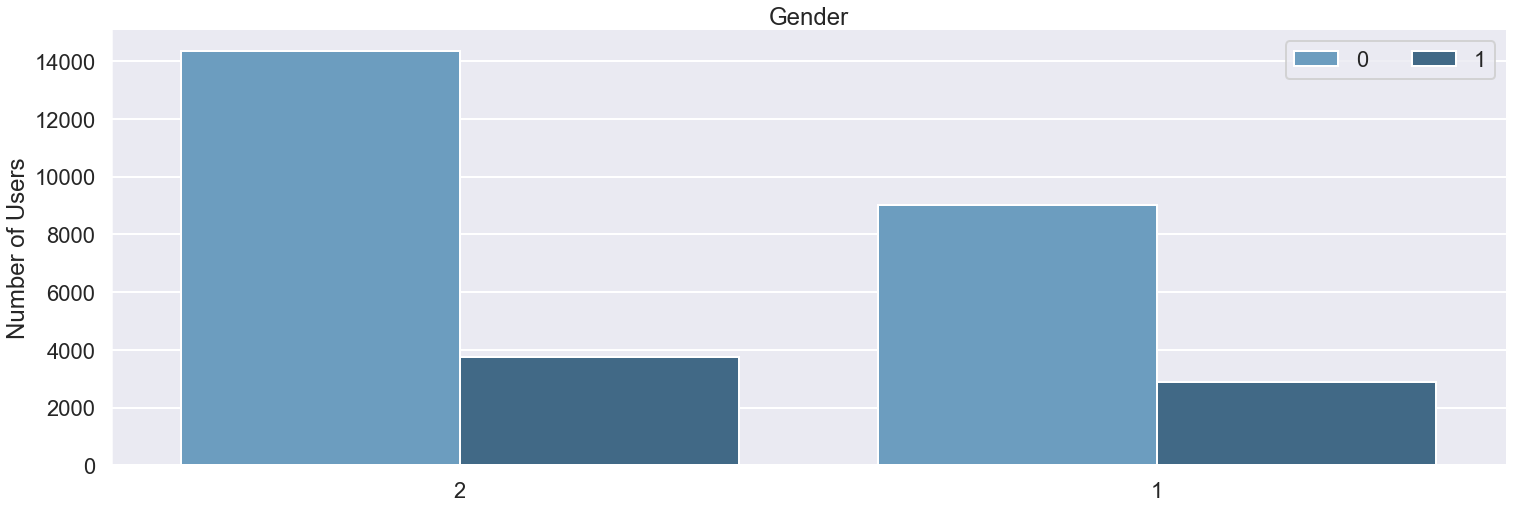

In [165]:
draw_plot(dataset, 'SEX','Gender',0)

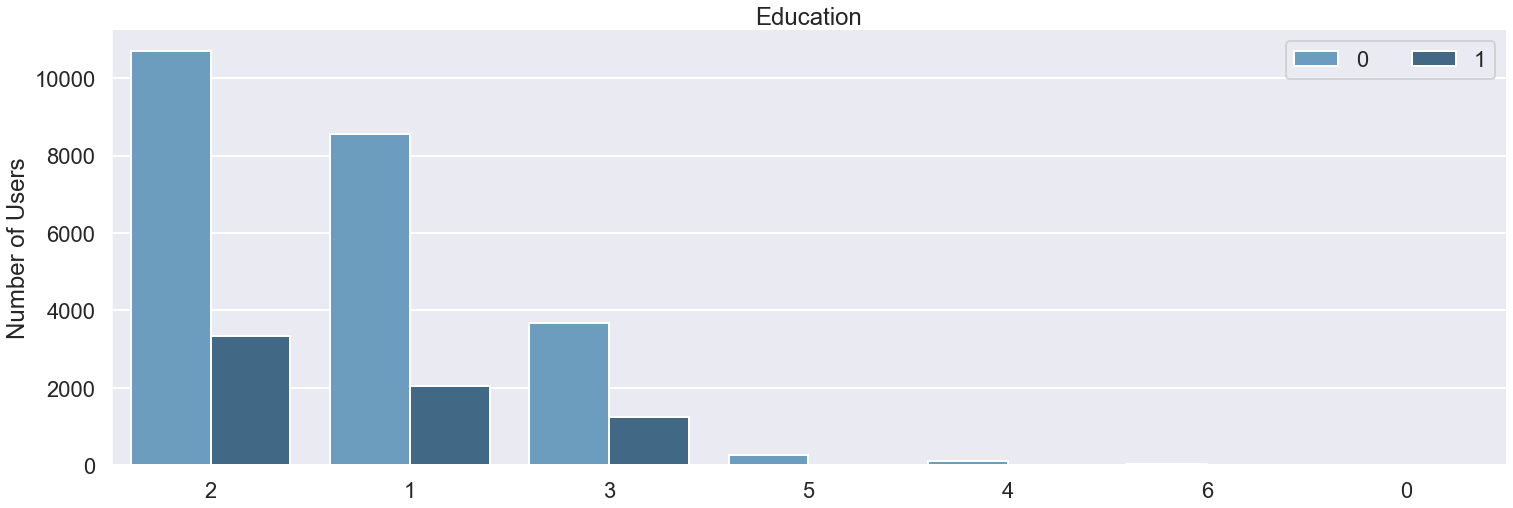

In [166]:
# Most users have 2 Education for both default and non-default users
draw_plot(dataset, 'EDUCATION','Education',0)

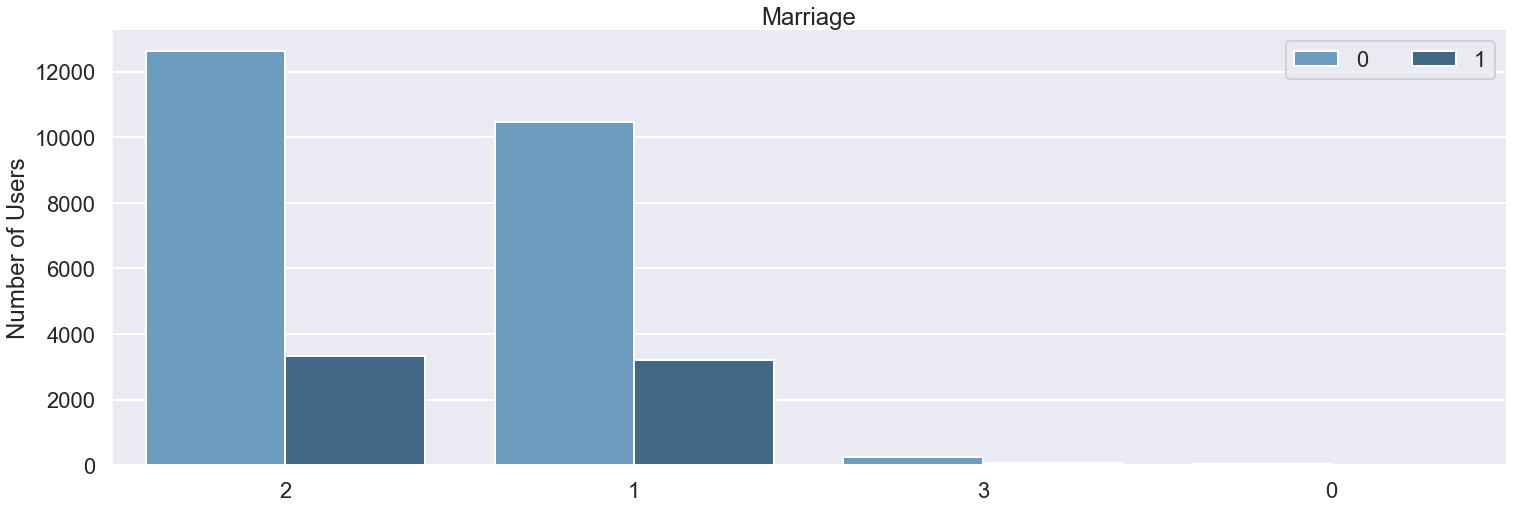

In [167]:
# Most users have 2 Education for both default and non-default users
draw_plot(dataset, 'MARRIAGE','Marriage',0)

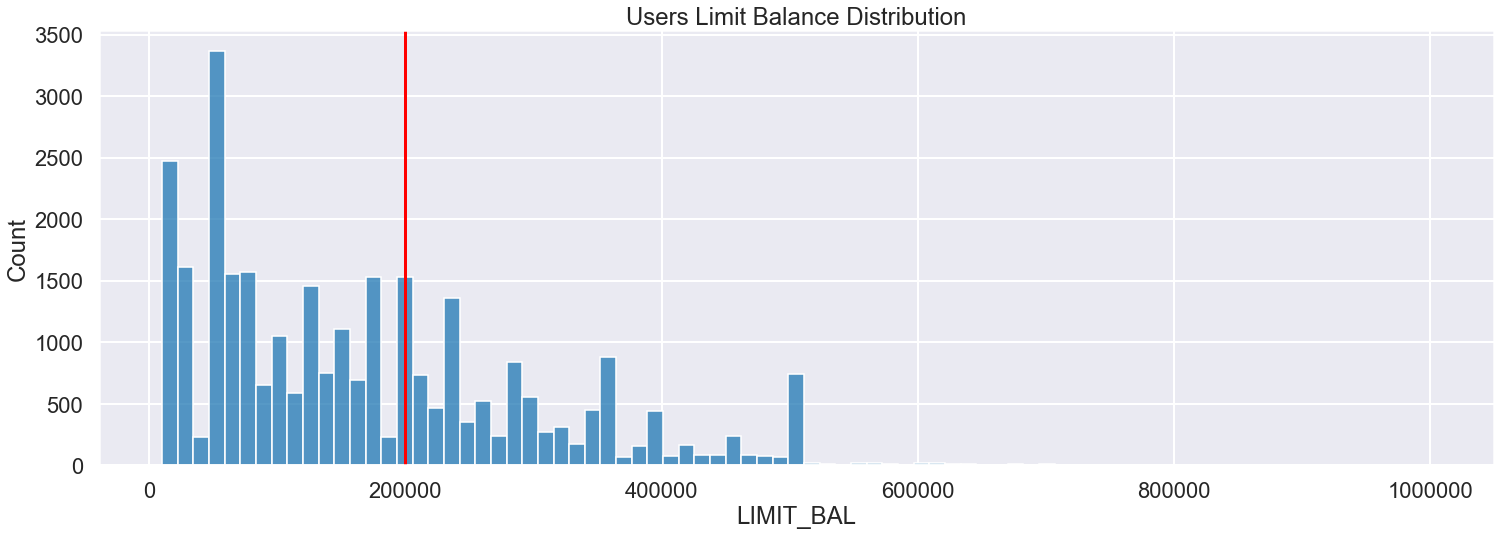

In [159]:
# distribution for limit balance
# the majority of the users from this dataset have less than 200K
# with 50k being the peak limit balance value

plt.figure(figsize=(25,8))
plt.title('Users Limit Balance Distribution')
sns.histplot(dataset.LIMIT_BAL)
plt.axvline(200000, color='red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

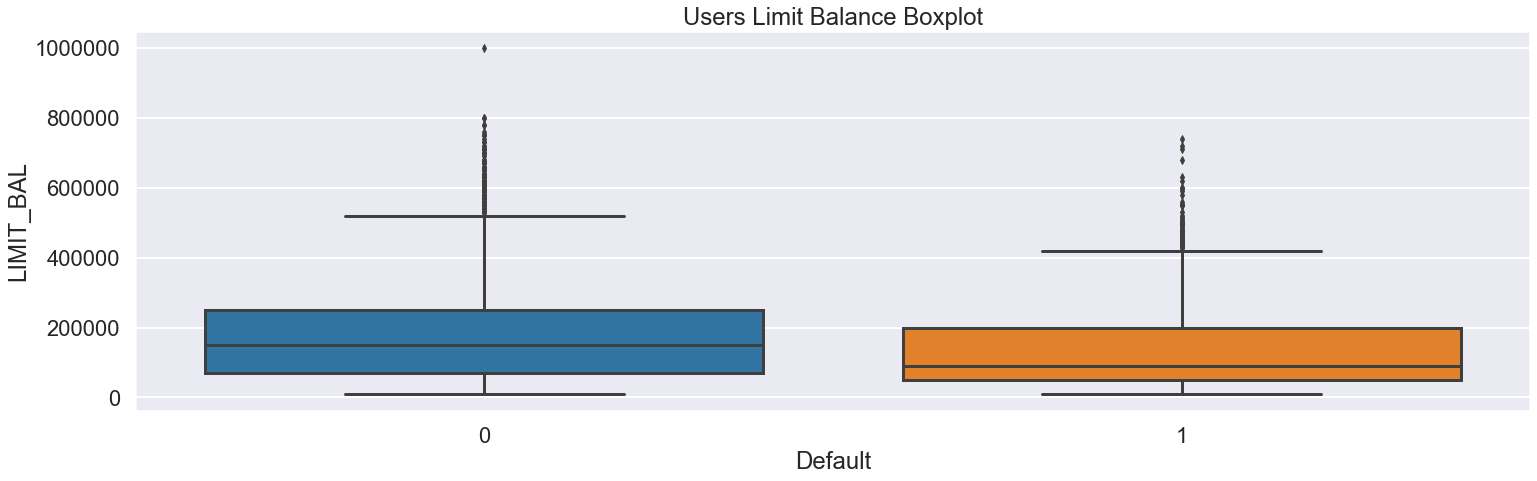

In [145]:
# there's not much difference in limit balance between the 2 groups
# confirmed that default users have lower limit balance in this dataset

    
# plot Limit Balance Boxplot    
draw_boxplot('Default', 'LIMIT_BAL','Users Limit Balance Boxplot')

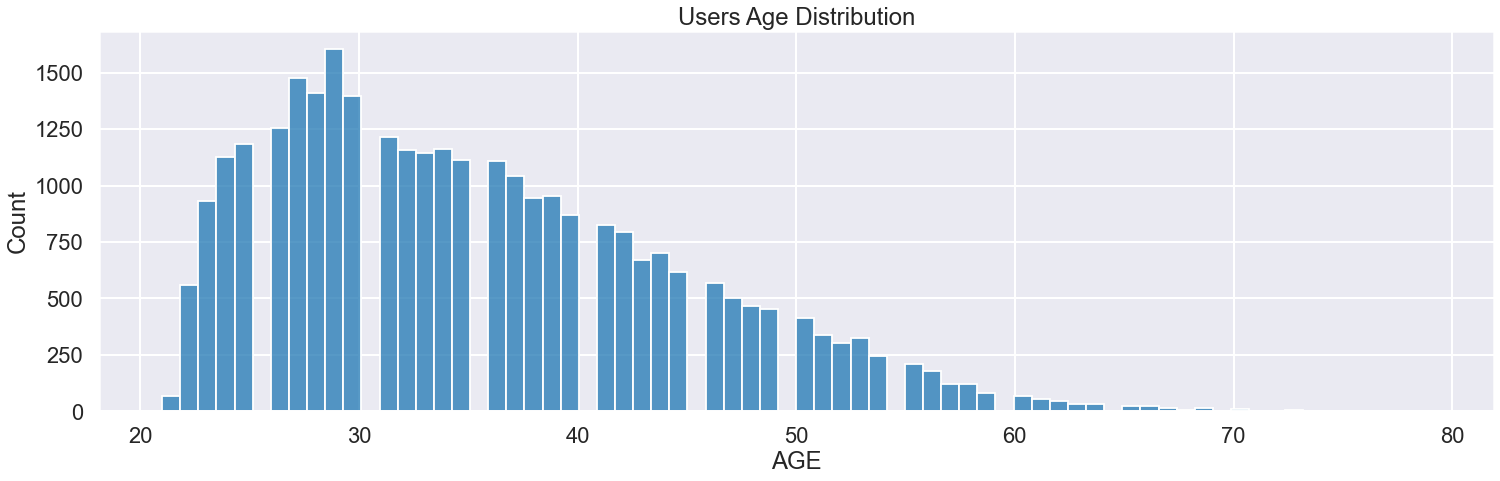

In [147]:
plt.figure(figsize=(25,7))
plt.title('Users Age Distribution')
sns.histplot(dataset.AGE)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

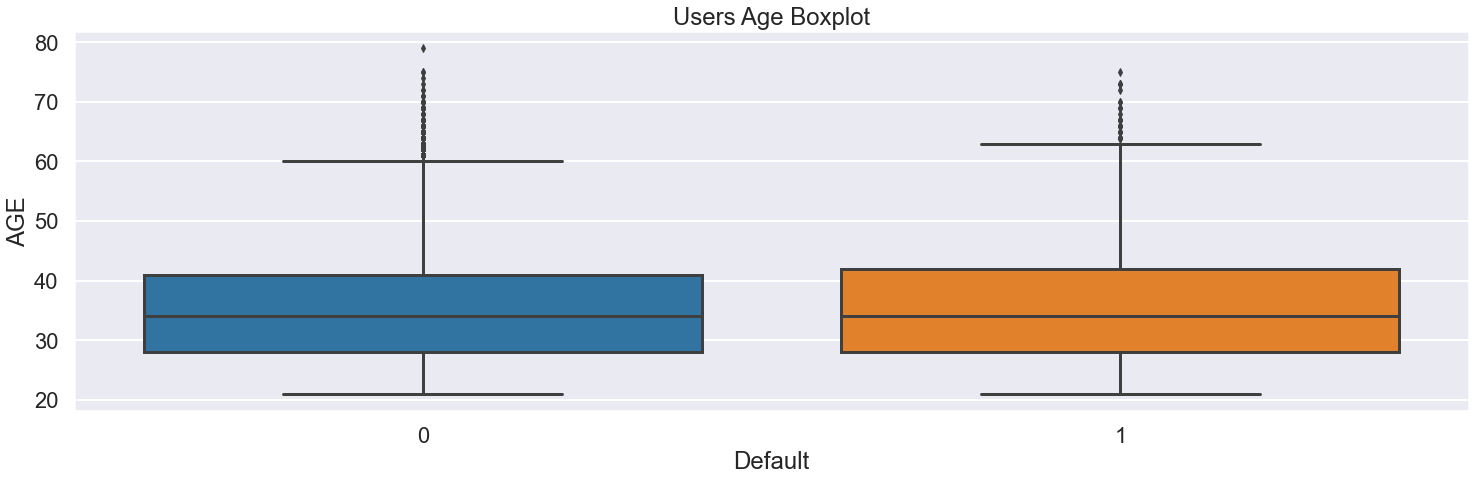

In [148]:
# plot Limit Balance Boxplot 
# there's almost no difference in age between the 2 groups
draw_boxplot('Default', 'AGE','Users Age Boxplot')

In [320]:
# generate new features 

dataset['TOTAL_PAID']=dataset[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 
         'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

dataset['TOTAL_BILLED']=dataset[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

In [322]:
dataset['LEFT_TO_PAY']=dataset['TOTAL_BILLED']-dataset['TOTAL_PAID']

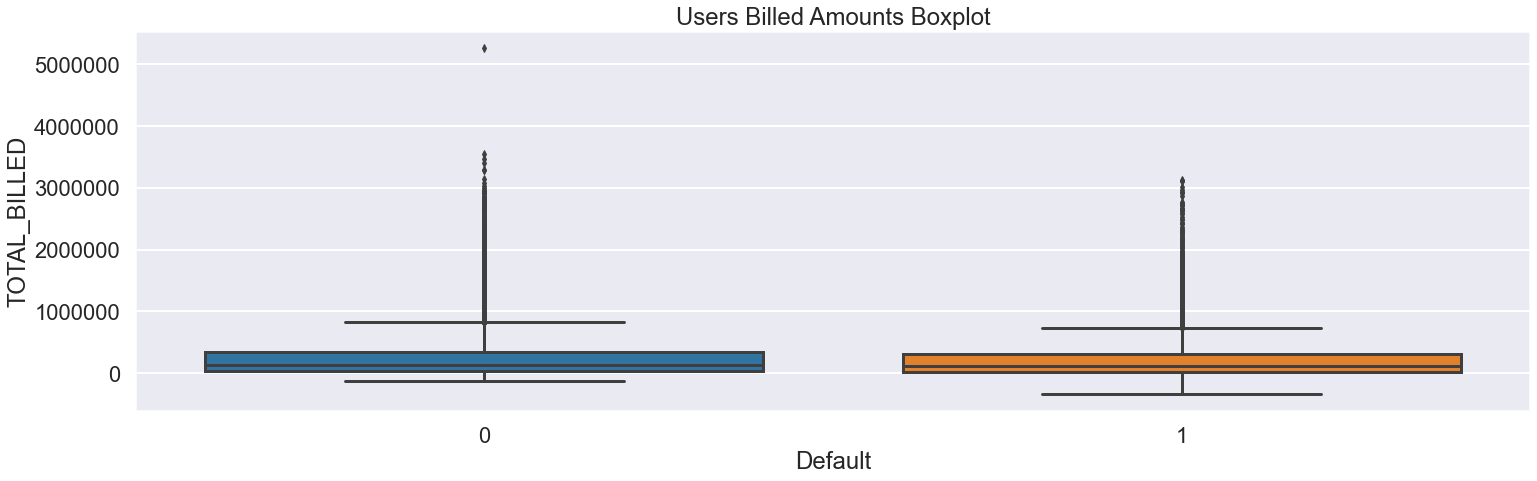

In [151]:
# there's almost no difference in Billed statements

draw_boxplot('Default', 'TOTAL_BILLED','Users Billed Amounts Boxplot')

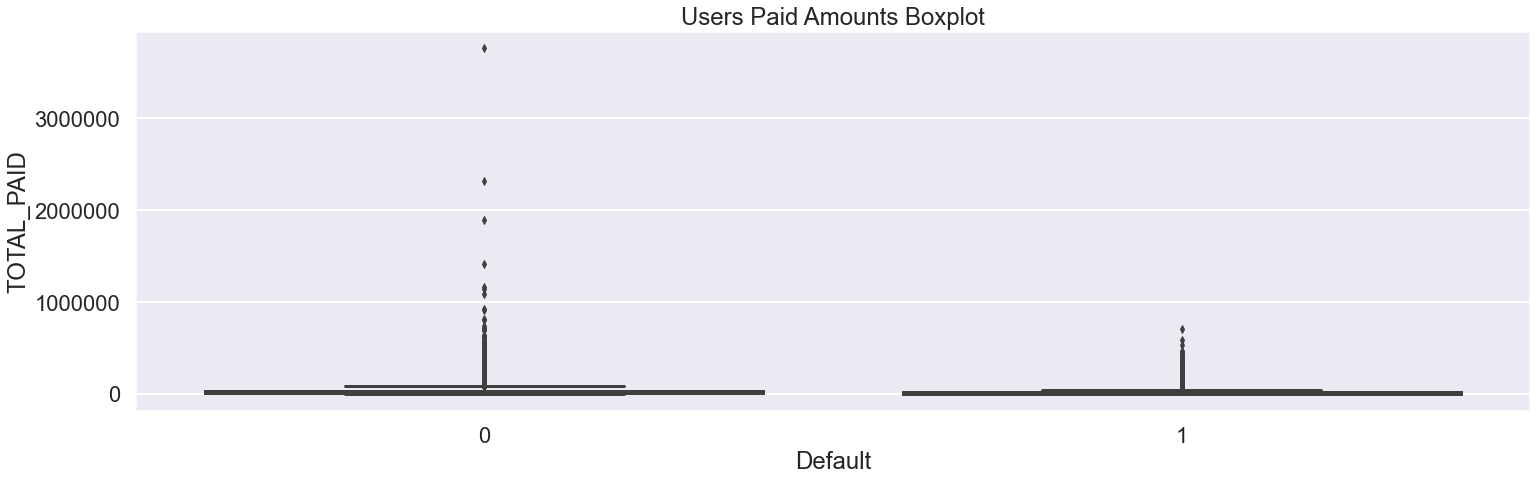

In [152]:
# non-default users have higher total paid ammounts
draw_boxplot('Default', 'TOTAL_PAID','Users Paid Amounts Boxplot')

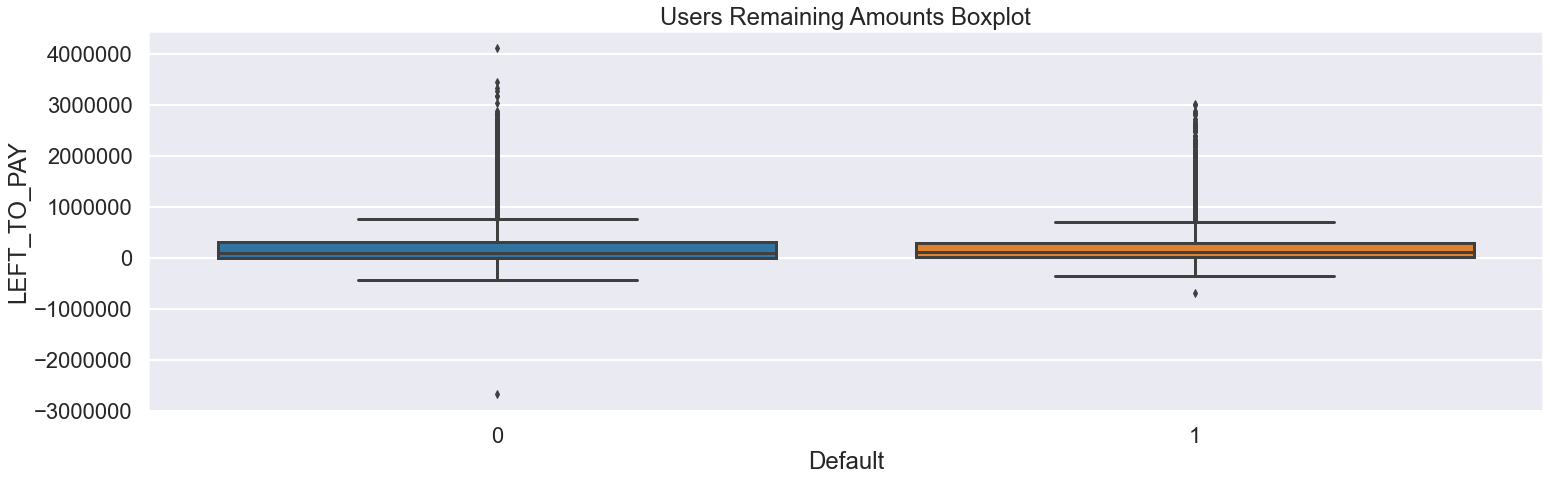

In [153]:
# we might think default users have higher remaining amounts to pay for
# but it seems like it may not be the case here

draw_boxplot('Default', 'LEFT_TO_PAY','Users Remaining Amounts Boxplot')

<AxesSubplot:>

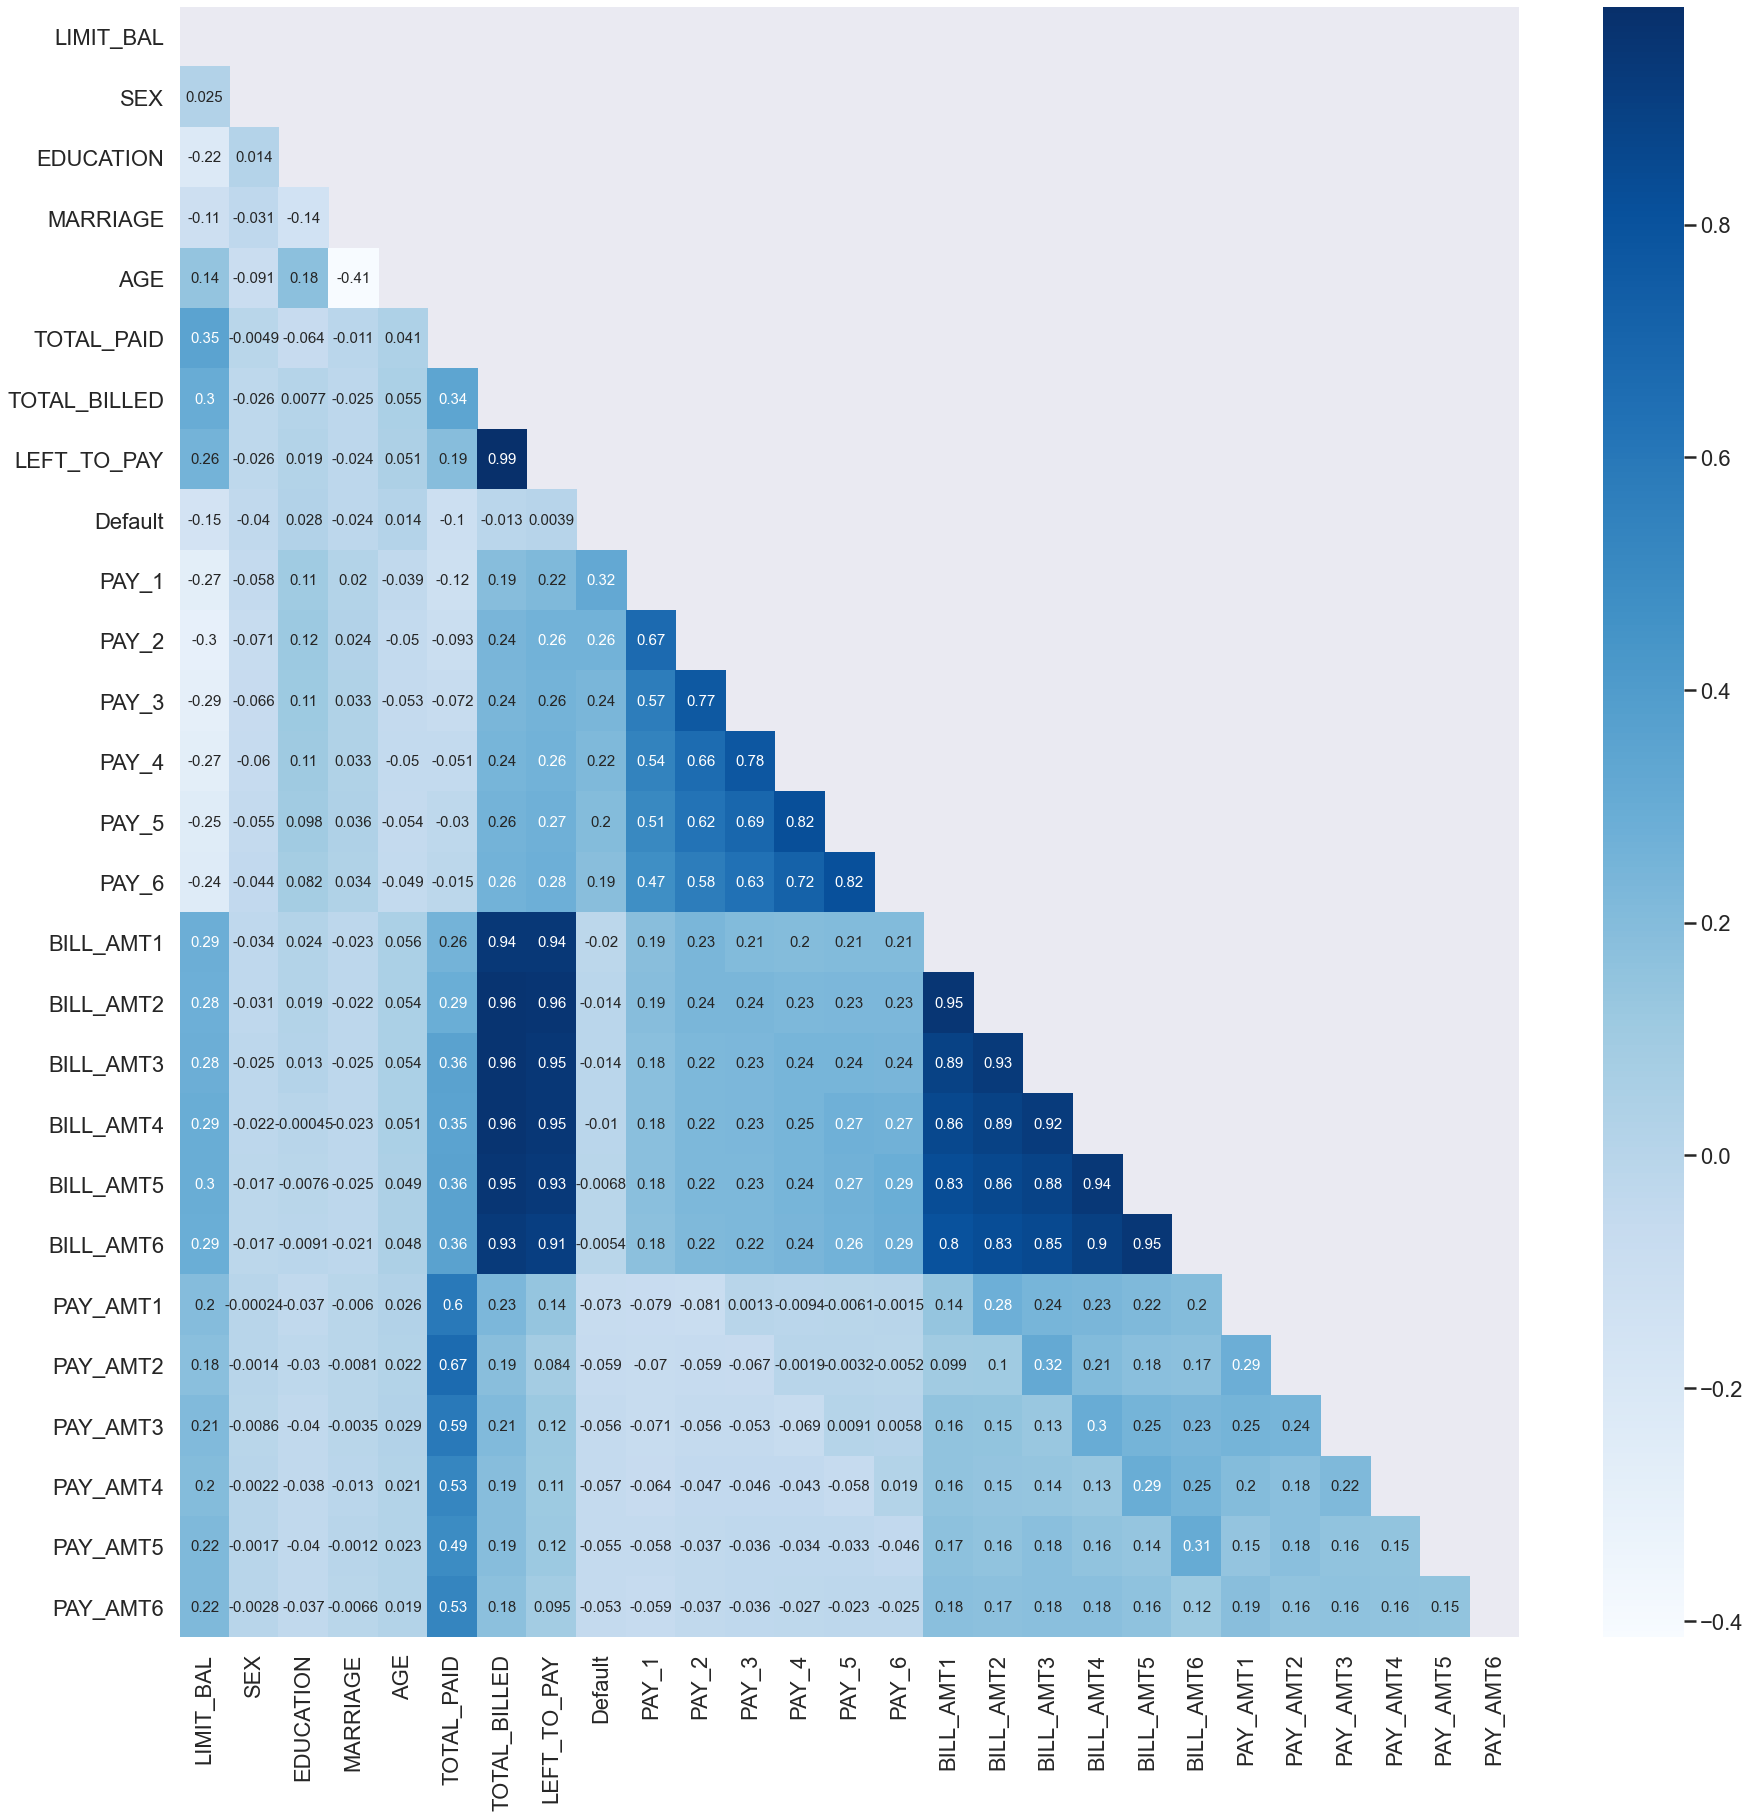

In [451]:
# Total paid and total billed are not highly correlated
# Default is not correlated with other variables
# we will need to drop either TOTAL_BILLED OR LEFT_TO_PAY since they have strong correlations 
# with some other similar features, which may cause redundancy 

corrdata=dataset[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                  'TOTAL_PAID', 'TOTAL_BILLED',
                  'LEFT_TO_PAY','Default',
                   'PAY_1', 'PAY_2',
                   'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
                   'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                   'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
                 ]]
corr = corrdata.corr()
plt.figure(figsize=(30,30))
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, annot_kws={"size": 15}, cmap="Blues")

<AxesSubplot:title={'center':'Correlation with Default'}>

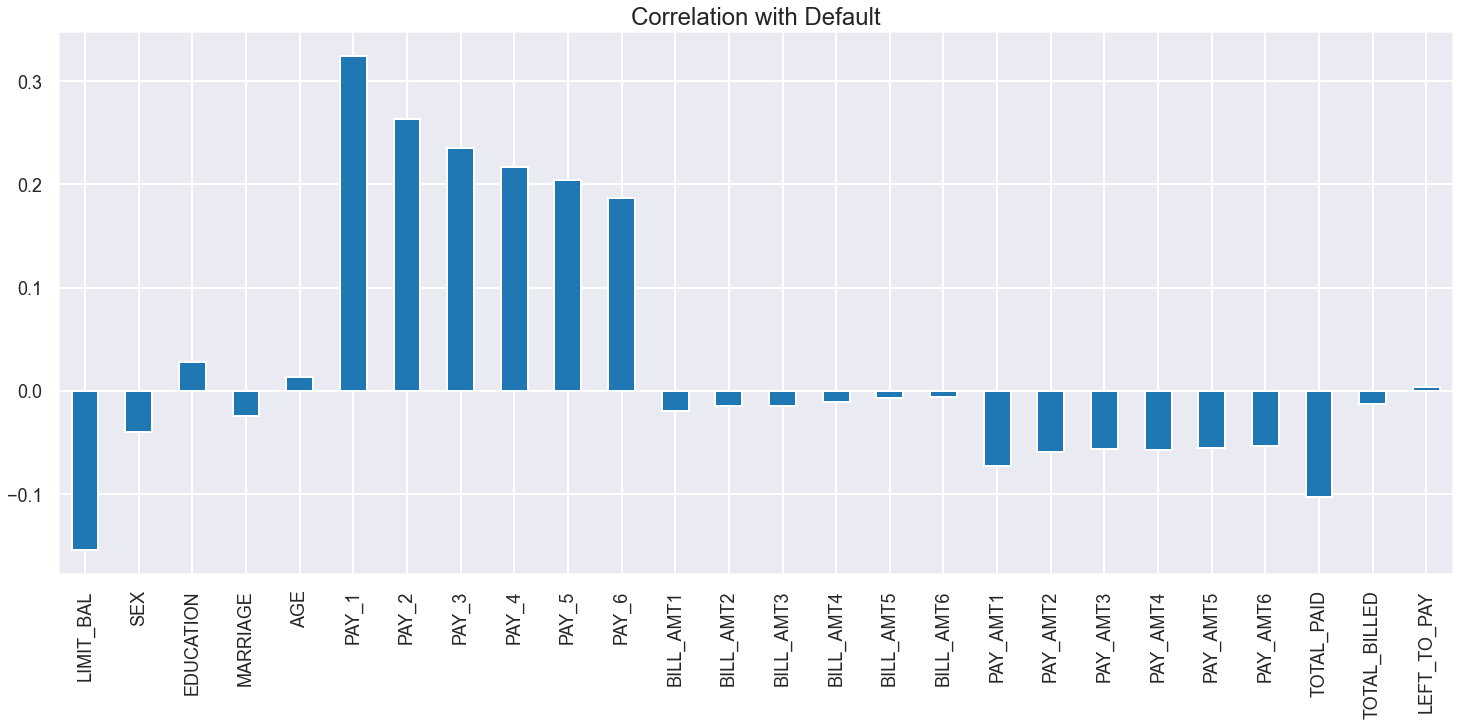

In [452]:
# for more detailed on correlation 
# Pay_0 - 6 have relatively higher correlation with Default

X = dataset.drop(['Default'],axis=1)
X.corrwith(dataset['Default']).plot.bar(figsize = (25, 10), title = "Correlation with Default", 
                                        fontsize = 18,rot = 90, grid = True)

<AxesSubplot:xlabel='EDUCATION', ylabel='PAY_1'>

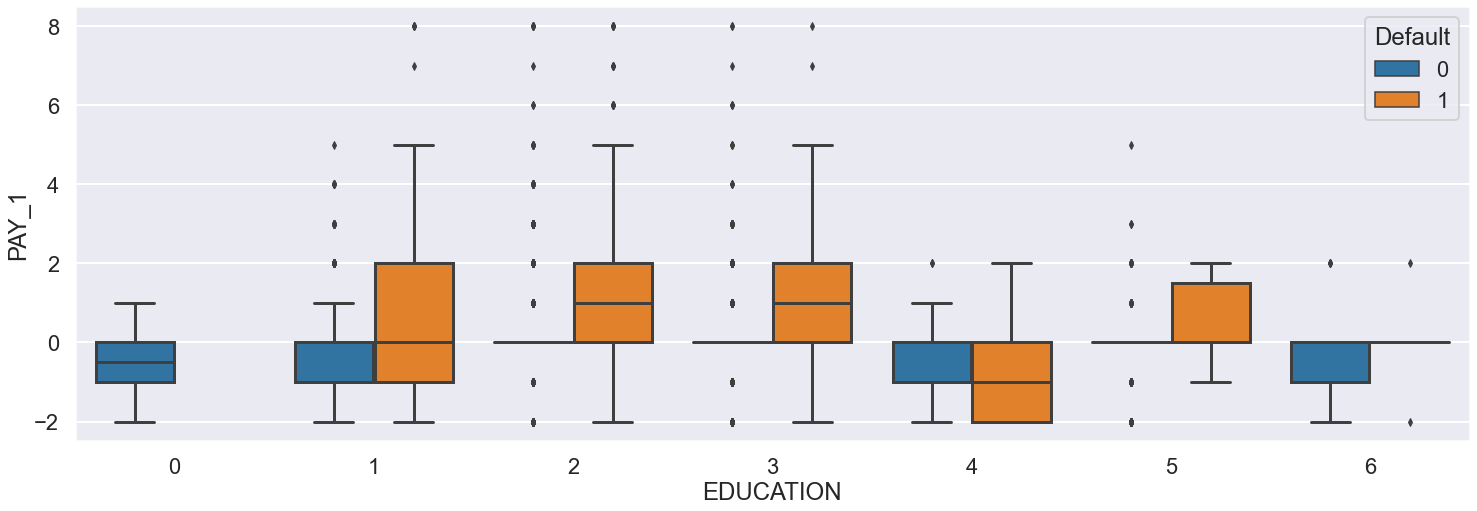

In [455]:
plt.figure(figsize=(25,8))
sns.boxplot(x= 'EDUCATION', y = 'PAY_1',data=dataset, 
            hue = 'Default')

## II. Model Training

We will use F1 score for model comparison since the classes are imbalanced, and there is a serious downside to predicting false negatives -- predicting the users will not default but it end up default. We do not want to allow any defaults to pass through because it would cause us money, so our best model will minimize False Negatives.

- a. Data Preprocessing
- b. Upsampling, Downsampling Dataset Pipeline
- c. Model Comparison Pipeline
- d. Feature Engineering (dropping columns, applying standard scalar)
- e. Hyperparameter Tuning

### a. Data Preprocessing

In [562]:
dataset.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default',
       'TOTAL_PAID', 'TOTAL_BILLED', 'LEFT_TO_PAY'],
      dtype='object')

In [648]:
# categorical data

# one-hot encoding
dataset_new=pd.concat([pd.get_dummies(dataset['SEX'], prefix='SEX'),
                pd.get_dummies(dataset['EDUCATION'], prefix='EDUCATION'), 
                pd.get_dummies(dataset['MARRIAGE'], prefix='MARRIAGE'),
                pd.get_dummies(dataset['PAY_1'], prefix='PAY_1'),
                dataset],axis=1)

In [649]:
# drop original columns
dataset_new.drop(['EDUCATION'],axis=1, inplace=True)
dataset_new.drop(['SEX'],axis=1, inplace=True)
dataset_new.drop(['MARRIAGE'],axis=1, inplace=True)
dataset_new.drop(['PAY_1'],axis=1, inplace=True)


### b. Upsampling, Downsampling Dataset Pipeline

In [499]:
def train_data(data, method):
    X = data.loc[:, data.columns!='Default']
    y = data['Default']

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=0)  


    # 1. Upsampling minority class

    X_smoted_train, y_smoted_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_resample(X_train, y_train)


    # 2. Downsample majority class

    # Separate majority and minority classes
    df_majority = data[data.Default==0]
    df_minority = data[data.Default==1]


    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])


    # df_downsampled

    X = df_downsampled.loc[:, df_downsampled.columns!='Default']
    y = df_downsampled['Default']

    X_down_train, X_down_test, y_down_train, y_down_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=0)  

    if method =='SMOTE':
        return X_smoted_train, y_smoted_train, X_test, y_test
    if method =='ADASYN':
        return X_adasyn_train, y_adasyn_train, X_test, y_test
    if method =='DOWNSAMPLE':
        return X_down_train, X_down_test, y_down_train, y_down_test
    else:
        return X_train, X_test, y_train, y_test

In [650]:
X_smoted_train, y_smoted_train, X_test, y_test = train_data(dataset_new,'SMOTE')
X_adasyn_train, y_adasyn_train, X_test, y_test = train_data(dataset_new,'ADASYN')
X_down_train, X_down_test, y_down_train, y_down_test = train_data(dataset_new,'DOWNSAMPLE')

### c. Model Comparison Pipeline

In [732]:
def make_pipeline():
    '''
    Create a single pipeline that processing the data 
    and then fits different classification models.
    '''  
    
    rf = RandomForestClassifier(random_state=50)
    gb=GradientBoostingClassifier(random_state=50)
    ada=AdaBoostClassifier(random_state=50)
    lr = LogisticRegression(random_state=50, max_iter=1000)
    classifiers=[rf,gb,ada,lr]

    pipeline = []
    for classifier in classifiers:
        pipe = Pipeline(steps=[('classifier', classifier)])
        pipeline.append(pipe)

    return pipeline

def sort_models(pipelines, X_data, y_data):
    '''
    Fit Data into the pipeline models and
    compute models' f1, recall, roc-auc scores.
    return sorted scores with its classifier name 
    '''
    scores = []
    for pipe in pipelines:
        y_pred = pipe.predict(X_data)
        f1score = f1_score(y_data, y_pred, average='weighted')
        recallscore=recall_score(y_data,y_pred)
        accuracyscore=accuracy_score(y_data,y_pred)

        aucscore=roc_auc_score(y_data, pipe.predict_proba(X_data)[:,1])
        
        classfier_name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        scores.append([classfier_name,f1score,recallscore,accuracyscore,aucscore])
        
    scores_sorted = sorted(scores,key=lambda x:x[1],reverse=True)
    
    return scores_sorted

def plot_metrics(data, title):
    '''
    Plot metrics among different models
    '''
    plt.figure(figsize=(25, 9))
    plt.title(title,fontsize=20)
    ax = sns.barplot(x="Model", y="value", hue = "variable",data=data)
    ax.legend(bbox_to_anchor=(1.0, 1.05));

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1]) #TP/TP+FP
#             How much were correctly classified as positive out of all positives.
            recall    = cf[1,1] / sum(cf[1,:]) #TP/TP+FN
            specificity = cf[0,0] / sum(cf[0,:]) #TN/TN+FP 
        
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nSpecificity={:0.3f}".format(
                accuracy,precision,recall,specificity,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [744]:
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train, y_smoted_train)

# apply sort_models function from above
smoted_sorted_model = sort_models(smote_pipelines, X_test, y_test)
smoted_sort_model_df = pd.DataFrame(smoted_sorted_model)
smoted_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
smoted_sort_model_df_melt = pd.melt(smoted_sort_model_df,id_vars=['Model'])

In [745]:
smoted_sort_model_df 

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.807623,0.387868,0.826267,0.781458
1,AdaBoostClassifier,0.802072,0.417279,0.815600,0.756140
2,RandomForestClassifier,0.799210,0.411152,0.812933,0.760456
3,LogisticRegression,0.696696,0.354779,0.689867,0.637084


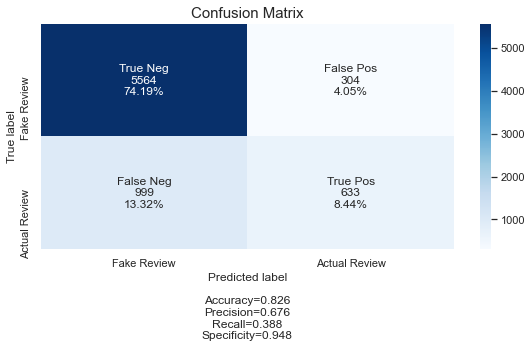

In [746]:
y_pred_smoted=smote_pipelines[1].predict(X_test)
cm_smoted= confusion_matrix(y_test, y_pred_smoted)

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();
    


In [739]:
adasyn_pipelines = make_pipeline()
# Train all the models
for pipe in adasyn_pipelines:
    pipe.fit(X_adasyn_train, y_adasyn_train)
    
# apply sort_models function from above
adasyn_sorted_model = sort_models(adasyn_pipelines, X_test, y_test)
adasyn_sort_model_df = pd.DataFrame(adasyn_sorted_model)
adasyn_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
adasyn_sort_model_df_melt = pd.melt(adasyn_sort_model_df,id_vars=['Model'])

In [740]:
adasyn_sort_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.808707,0.382966,0.828267,0.781913
1,AdaBoostClassifier,0.803705,0.419118,0.817333,0.757799
2,RandomForestClassifier,0.798681,0.409314,0.812533,0.758940
3,LogisticRegression,0.694633,0.346814,0.688133,0.636464


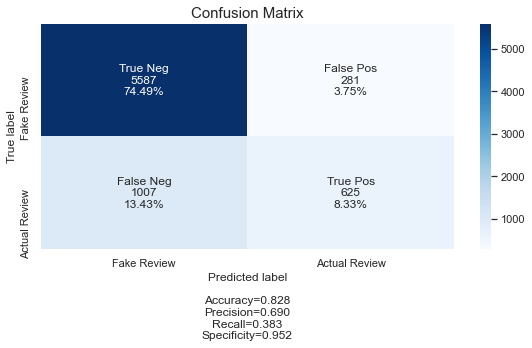

In [743]:
y_pred_adasyn=adasyn_pipelines[1].predict(X_test)
cm_adasyn= confusion_matrix(y_test, y_pred_adasyn)

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_adasyn, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [733]:
# downsampling

downsample_pipelines = make_pipeline()
# Train all the models
for pipe in downsample_pipelines:
    pipe.fit(X_down_train, y_down_train)

# apply sort_models function from above
down_sorted_model = sort_models(downsample_pipelines, X_down_test, y_down_test)
down_sorted_model_df = pd.DataFrame(down_sorted_model)
down_sorted_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
down_sorted_model_df_melt = pd.melt(down_sorted_model_df,id_vars=['Model'])

In [734]:
down_sorted_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.724410,0.639102,0.726341,0.790266
1,AdaBoostClassifier,0.720598,0.621382,0.723327,0.782566
2,RandomForestClassifier,0.710972,0.636740,0.712477,0.782725
3,LogisticRegression,0.617740,0.724158,0.622061,0.657301


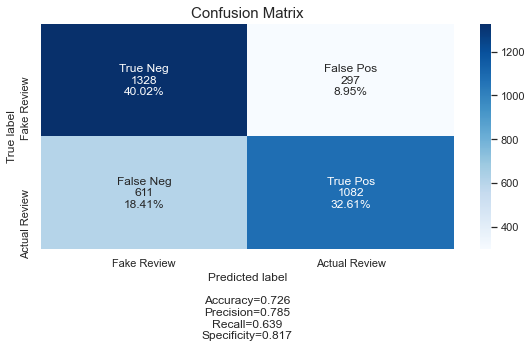

In [738]:
y_pred_down=downsample_pipelines[1].predict(X_down_test)
cm_down= confusion_matrix(y_down_test,y_pred_down )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_down, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

### d. Feature Engineering

### **✅ I.  Dropping Correlated Columns

In [662]:
# let's drop the bill columns
dataset_new_2=dataset_new.drop(['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5','BILL_AMT6',
                                'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6'
                               ], axis=1)

In [663]:
X_smoted_train_2, y_smoted_train_2, X_test_2, y_test_2 = train_data(dataset_new_2,'SMOTE')
X_adasyn_train_2, y_adasyn_train_2, X_test_2, y_test_2 = train_data(dataset_new_2,'ADASYN')
X_down_train_2, X_down_test_2, y_down_train_2, y_down_test_2 = train_data(dataset_new_2,'DOWNSAMPLE')

In [747]:
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train_2, y_smoted_train_2)

# apply sort_models function from above
smoted_sorted_model = sort_models(smote_pipelines, X_test_2, y_test_2)
smoted_sort_model_df = pd.DataFrame(smoted_sorted_model)
smoted_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
smoted_sort_model_df_melt = pd.melt(smoted_sort_model_df,id_vars=['Model'])

In [748]:
smoted_sort_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.809595,0.386642,0.828800,0.771588
1,AdaBoostClassifier,0.806236,0.411765,0.821333,0.759582
2,RandomForestClassifier,0.792773,0.389706,0.808000,0.747045
3,LogisticRegression,0.691093,0.351716,0.682933,0.630591


In [749]:
# best smote model performanxce -- gradientboosting
y_pred_smoted_2=smote_pipelines[1].predict(X_test_2)

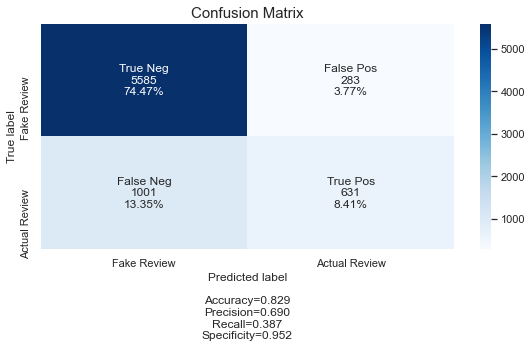

In [750]:
cm_smoted_2= confusion_matrix(y_test_2,y_pred_smoted_2 )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [751]:
adasyn_pipelines = make_pipeline()
# Train all the models
for pipe in adasyn_pipelines:
    pipe.fit(X_adasyn_train_2, y_adasyn_train_2)
    
# apply sort_models function from above
adasyn_sorted_model = sort_models(adasyn_pipelines, X_test_2, y_test_2)
adasyn_sort_model_df = pd.DataFrame(adasyn_sorted_model)
adasyn_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
adasyn_sort_model_df_melt = pd.melt(adasyn_sort_model_df,id_vars=['Model'])
# plot_metrics(adasyn_sort_model_df_melt, 'Models using ADASYN Upsampling Data')

In [752]:
adasyn_sort_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.805531,0.370711,0.826267,0.771744
1,AdaBoostClassifier,0.804073,0.387868,0.822000,0.755627
2,RandomForestClassifier,0.791956,0.381740,0.808133,0.742243
3,LogisticRegression,0.559343,0.769608,0.524267,0.649169


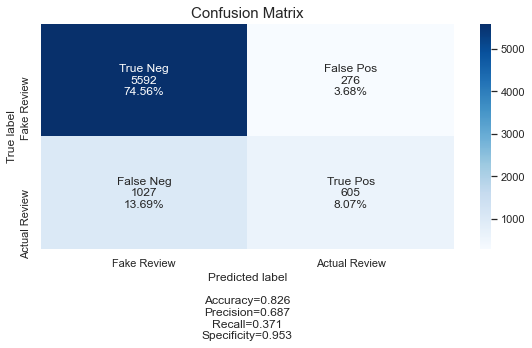

In [753]:
# best adasyn model performanxce -- gradientboosting
y_pred_adasyn_2=adasyn_pipelines[1].predict(X_test_2)

cm_adasyn_2= confusion_matrix(y_test_2,y_pred_adasyn_2 )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_adasyn_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [754]:
# downsampling

downsample_pipelines = make_pipeline()
# Train all the models
for pipe in downsample_pipelines:
    pipe.fit(X_down_train_2, y_down_train_2)
    
# apply sort_models function from above
down_sorted_model = sort_models(downsample_pipelines, X_down_test_2, y_down_test_2)
down_sorted_model_df = pd.DataFrame(down_sorted_model)
down_sorted_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
down_sorted_model_df_melt = pd.melt(down_sorted_model_df,id_vars=['Model'])
# plot_metrics(down_sorted_model_df_melt, 'Models using Downsampling Data')

In [755]:
down_sorted_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.704874,0.623745,0.706751,0.773223
1,AdaBoostClassifier,0.697642,0.597165,0.700723,0.765662
2,RandomForestClassifier,0.690916,0.629652,0.691983,0.762578
3,LogisticRegression,0.613062,0.717070,0.617239,0.652435


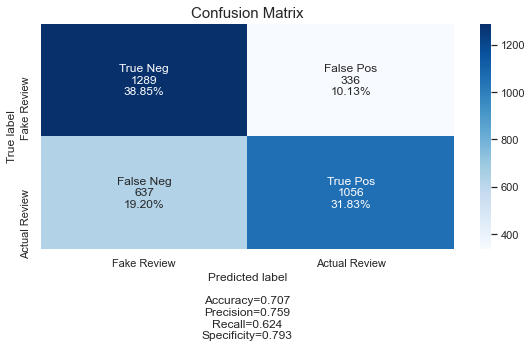

In [756]:
y_pred_down_2=downsample_pipelines[1].predict(X_down_test_2)
cm_down_2= confusion_matrix(y_down_test,y_pred_down_2 )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_down_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

### **❌II.  Standard Scaler

In [522]:
# Define function to rescale training data using StandardScaler

def standard_scaler(X_train, X_test, numerical_cols):
    
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
        scl = StandardScaler().fit(X_train_std[[i]])     # fit on training data columns
        X_train_std[i] = scl.transform(X_train_std[[i]]) # transform the training data columns
        X_test_std[i] = scl.transform(X_test_std[[i]])   # transform the testing data columns
    
    return X_train_std,X_test_std

In [532]:
# Rescale data using the old dataset
from sklearn.preprocessing import StandardScaler

In [668]:
# apply StandardScaler

X_df=dataset_new_2.iloc[:, dataset_new_2.columns!='Default']
scaled_features = StandardScaler().fit_transform(X_df.values)
# put scaled values in a dataframe
scaled_features_df = pd.DataFrame(scaled_features, index=X_df.index, columns=X_df.columns)
# add back in the target column
scaled_features_df['Default']=dataset_new['Default']

In [669]:
# Rescale data

X_smoted_train_scaled, y_smoted_train_scaled, X_test_scaled, y_test_scaled = train_data(scaled_features_df,'SMOTE')
X_adasyn_train_scaled, y_adasyn_train_scaled, X_test_scaled, y_test_scaled = train_data(scaled_features_df,'ADASYN')
X_down_train_scaled, X_down_test_scaled, y_down_train_scaled, y_down_test_scaled = train_data(scaled_features_df,'DOWNSAMPLE')


In [730]:
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train_scaled, y_smoted_train_scaled)

# apply sort_models function from above
smoted_sorted_model = sort_models(smote_pipelines, X_test_scaled, y_test_scaled)
smoted_sort_model_df = pd.DataFrame(smoted_sorted_model)
smoted_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
smoted_sort_model_df_melt = pd.melt(smoted_sort_model_df,id_vars=['Model'])
# plot_metrics(smoted_sort_model_df_melt, 'Models using Smoted Upsampling Data')

In [731]:
smoted_sort_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,RandomForestClassifier,0.781381,0.475490,0.783600,0.740207
1,GradientBoostingClassifier,0.779247,0.534314,0.775467,0.765512
2,LogisticRegression,0.777429,0.568627,0.770533,0.759033
3,AdaBoostClassifier,0.771951,0.553309,0.765067,0.750827


In [ ]:
# best adasyn model performanxce -- gradientboosting
y_pred_adasyn_2=adasyn_pipelines[1].predict(X_test_2)

cm_adasyn_2= confusion_matrix(y_test_2,y_pred_adasyn_2 )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_adasyn_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [672]:
adasyn_pipelines = make_pipeline()
# Train all the models
for pipe in adasyn_pipelines:
    pipe.fit(X_adasyn_train_scaled, y_adasyn_train_scaled)
    
# apply sort_models function from above
adasyn_sorted_model = sort_models(adasyn_pipelines, X_test_scaled, y_test_scaled)
adasyn_sort_model_df = pd.DataFrame(adasyn_sorted_model)
adasyn_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
adasyn_sort_model_df_melt = pd.melt(adasyn_sort_model_df,id_vars=['Model'])

In [673]:
adasyn_sort_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,RandomForestClassifier,0.775090,0.490196,0.774400,0.738667
1,GradientBoostingClassifier,0.771433,0.564338,0.763600,0.760623
2,LogisticRegression,0.751329,0.609069,0.736400,0.757941
3,AdaBoostClassifier,0.750620,0.617647,0.735067,0.754860


In [674]:
# downsampling

downsample_pipelines = make_pipeline()
# Train all the models
for pipe in downsample_pipelines:
    pipe.fit(X_down_train_2, y_down_train_2)
    
# apply sort_models function from above
down_sorted_model = sort_models(downsample_pipelines, X_down_test_2, y_down_test_2)
down_sorted_model_df = pd.DataFrame(down_sorted_model)
down_sorted_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
down_sorted_model_df_melt = pd.melt(down_sorted_model_df,id_vars=['Model'])

In [675]:
down_sorted_model_df

,Model,F1 Score,Recall Score,Accuracy Score,AUC Score
0,GradientBoostingClassifier,0.704874,0.623745,0.706751,0.773223
1,AdaBoostClassifier,0.697642,0.597165,0.700723,0.765662
2,RandomForestClassifier,0.690916,0.629652,0.691983,0.762578
3,LogisticRegression,0.613062,0.717070,0.617239,0.652435


As we see here, all the metrics are lower using the none-scaled data.
We will not consider scaled dataset, and we will choose the one-hot encoding dataset

### e. Hyperparameter Tuning

In [ ]:
def make_random_cv(clf):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate GridSearchCV
    """
    if clf._final_estimator.__class__.__name__ == 'GradientBoostingClassifier':

        
                #parameters to tune
        hyperparameters = {
#          'classifier__learning_rate': [0.01,0.05,0.1,0.5,1],
         'classifier__max_depth' : [5,7,9],
         'classifier__min_samples_split': list(range(2, 6))
#          'classifier__min_samples_leaf': list(range(1, 6)),
#          'classifier__max_features': list(range(1, 10))
        }

        clf_random_cv = GridSearchCV(clf,
                                     hyperparameters,
                                     cv=5,
                                     #optimize roc curve
                                     scoring='acur',
                                     refit=True,
                                     n_jobs=-1)

    return clf_random_cv

In [760]:
# USING THE DATASET WITH ONE HOT-ENCODING AND SMOTE
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train, y_smoted_train)

gb = make_random_cv(smote_pipelines[1])
gb_model = gb.fit(X_smoted_train, y_smoted_train)
print(gb_model.best_estimator_._final_estimator)

# use the best estimator to train the model
new_gb_model =gb_model.best_estimator_._final_estimator.fit(X_test,y_test)

GradientBoostingClassifier(max_depth=5, random_state=50)


In [761]:
y_pred_gb_1=new_gb_model.predict(X_test)

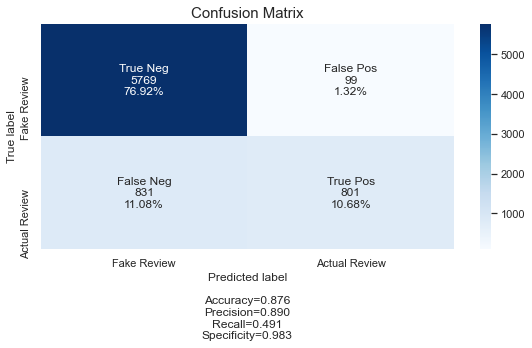

In [762]:
cm_smoted_opt_1= confusion_matrix(y_test,y_pred_gb_1)

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted_opt_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [765]:
f1score = f1_score(y_test, y_pred_gb_1, average='weighted')
recallscore=recall_score(y_test,y_pred_gb_1)
accuracyscore=accuracy_score(y_test,y_pred_gb_1)
# aucscore=roc_auc_score(y_test_2, pipe.predict_proba(X_test_2)[:,1])

print("f1 score: ", f1score)
print("recall score: ", recallscore)
print("accuracy score: ", accuracyscore)
# print("auc score: ", aucscore)

f1 score:  0.8617158678824426
recall score:  0.49080882352941174
accuracy score:  0.876


In [677]:
# USING THE DATASET WITH DROPPED COLUMNS AND SMOTE
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train_2, y_smoted_train_2)

gb = make_random_cv(smote_pipelines[1])
gb_model = gb.fit(X_smoted_train_2, y_smoted_train_2)
print(gb_model.best_estimator_._final_estimator)

# use the best estimator to train the model
new_gb_model_2 =gb_model.best_estimator_._final_estimator.fit(X_test_2,y_test_2)

In [758]:
y_pred_gb_2=new_gb_model.predict(X_test_2)

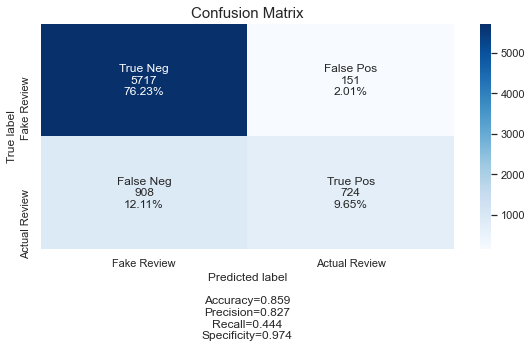

In [759]:
cm_smoted_opt_2= confusion_matrix(y_test_2,y_pred_gb_2)

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted_opt_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [764]:
f1score = f1_score(y_test_2, y_pred_gb, average='weighted')
recallscore=recall_score(y_test_2,y_pred_gb)
accuracyscore=accuracy_score(y_test_2,y_pred_gb)
# aucscore=roc_auc_score(y_test_2, pipe.predict_proba(X_test_2)[:,1])

print("f1 score: ", f1score)
print("recall score: ", recallscore)
print("accuracy score: ", accuracyscore)
# print("auc score: ", aucscore)

f1 score:  0.8417599420126807
recall score:  0.44362745098039214
accuracy score:  0.8588


## Conclusion

using the hot-encoding with SMOTE gave us the best f1 score and the lowest false negative rate.